<center>
<h1>Previsão de Óbito com base nos Dados de Pacientes</h1>
<img src="https://i0.wp.com/blog.dentalcremer.com.br/wp-content/uploads/2017/12/hospital-vera-cruz-campinas_1490193436_sepse2.jpg" alt="Sepse" width="300"/>
</center>

Uma das grandes problemáticas nos hospitais é a detecção tardia da deterioração clínica. O agravamento do quadro clínico de pacientes pode ter várias consequências; como a sepse, por exemplo, que soma mais de 6 milhões de mortes por ano mundialmente. Muitas dessas mortes poderiam ser evitadas com o reconhecimento antecipado do risco, isto é, da deterioração clínica. 

O diagnóstico da sepse geralmente sempre é feito de modo clínico e laboratorial ([fleury](https://www.fleury.com.br/manual-de-doencas/sepse)). Nos hospitais diversos exames são coletados dos pacientes com o propósito de escolher qual procedimento executar. Entretanto, o processo de análise desses exames geralmente é uma tarefa repetitiva e exaustiva, e requer muita atenção dos profissionais da saúde. 

Os dados desses exames podem ser analisadas através de sistemas computacionais conhecidos como *Computer-Aided Diagnosis (CAD)*. Esses sistemas são desenvolvidos com o propósito de serem úteis no diagnóstico de doenças, dando subsídio aos especialistas ao diminuir parte de tarefas repetivas e apontando informações sutis que possam ter passado despercebidas.

Nesse notebook, pretendemos analisar dados de aproxidamente 5000 pacientes com o propósito de identificar informações nos dados que possam ser relevantes na tarefa de classificar o risco de óbito de um paciente.

Esse notebook é dividido da seguinte maneira:

1. Leitura e pré-processamento dos dados
2. Análise exploratória dos dados
3. Tarefa de classificação



In [1]:
import pandas as pd
data=pd.read_csv('/content/laura1.csv',sep='\t')
data.head()

,idade,setor,temperatura,freq_respiratoria,pa_sistolica,pa_diastolica,pa_media,sat_o2,alta.motivo
0,87,UTIG,36.0,18.0,128.0,75.0,93.0,91.0,Obito
1,53,1AP2,35.4,14.0,117.0,67.0,84.0,100.0,Obito
2,63,UTIG,36.4,40.0,149.0,75.0,100.0,78.0,Obito
3,84,UTIG,36.4,40.0,149.0,75.0,100.0,78.0,Obito
4,99,4AP2,36.3,16.0,80.0,60.0,67.0,94.0,Obito


#Testes Estatísticos

Avaliamos se os dados são originados de uma distribuição Gaussiana. Checar isso nos ajuda a tomar decisões como se usar métodos paramétricos ou não-paramétricos, ou se é necessário a normalização dos dados futuramente.

In [ ]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson


In [ ]:
cols=['idade','freq_respiratoria','pa_sistolica','pa_diastolica','pa_media','sat_o2']

In [ ]:
def stats_tests(col):
  # teste de shapiro 
  stat, p = shapiro(data[col].values)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  # interpret
  alpha = 0.05
  if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
  else:
    print('Sample does not look Gaussian (reject H0)')


  # normality test
  stat, p = normaltest(data[col].values)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  # interpret
  alpha = 0.05
  if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
  else:
	  print('Sample does not look Gaussian (reject H0)')
   
  # normality test
  result = anderson(data[col].values)
  print('Statistic: %.3f' % result.statistic)
  p = 0
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
      print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
      print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [ ]:
for c in cols:
  print("*"*20)
  print(c)
  stats_tests(c)

********************
idade
Statistics=0.973, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=290.912, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 28.271
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)
********************
freq_respiratoria
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)
Statistics=nan, p=nan
Sample does not look Gaussian (reject H0)
Statistic: nan
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)
********************
pa_sistolica
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)
Statistic

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Com base nesses teste é necessário considerar o uso de métodos não paramétricos, ou uso de métodos de normalização.

#Exploração de Dados

In [7]:
# Bibliotecas utilizadas
import shutil
from zipfile import ZipFile
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

%matplotlib inline

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              5001 non-null   int64  
 1   setor              5000 non-null   object 
 2   temperatura        4998 non-null   float64
 3   freq_respiratoria  4996 non-null   float64
 4   pa_sistolica       4999 non-null   float64
 5   pa_diastolica      4999 non-null   float64
 6   pa_media           4999 non-null   float64
 7   sat_o2             3686 non-null   float64
 8   alta.motivo        5001 non-null   object 
dtypes: float64(6), int64(1), object(2)
memory usage: 351.8+ KB


 O nosso conjunto de dados contempla 9 variáveis, sendo a maioria do tipo real, duas do tipo string e a idade informada como inteiro. Aqui observamos a coluna `sat_o2` apresenta muitos dados faltantes com relação aos demais. Escolher remover todas as linhas que tem sat_os como `nan` pode ferir na performance. Algumas das estratégias que podem ser tomadas poderiam ser:
 - o preenchimento de dados faltantes
 - ou a remoção da coluna

Dentre os dados categóricos possuímos o setor e o motivo da alta.

In [9]:
data["setor"].value_counts()

4AP1          1034
2AP2           985
3AP3           677
3AP1           607
4AP2           475
1AP2           347
3AP2           298
UTIG           174
3AP3 - EPI     147
UTIC            66
1AP1            59
2AP1            51
UTIP            34
SEMI-CO         25
1AP2 - 126      19
UIP              2
Name: setor, dtype: int64

In [10]:
data["alta.motivo"].value_counts()

Melhorado    4572
Obito         429
Name: alta.motivo, dtype: int64

Podemos notar um desbalanceamento na coluna de alta, no qual maioria dos dados em nosso conjunto são de pacientes que obtiveram melhor. Diante disso, necessitamos investigar estratégias para lidar com esse desbalanceamento a fim de minimizar o erro de predição da classe *Óbito*.

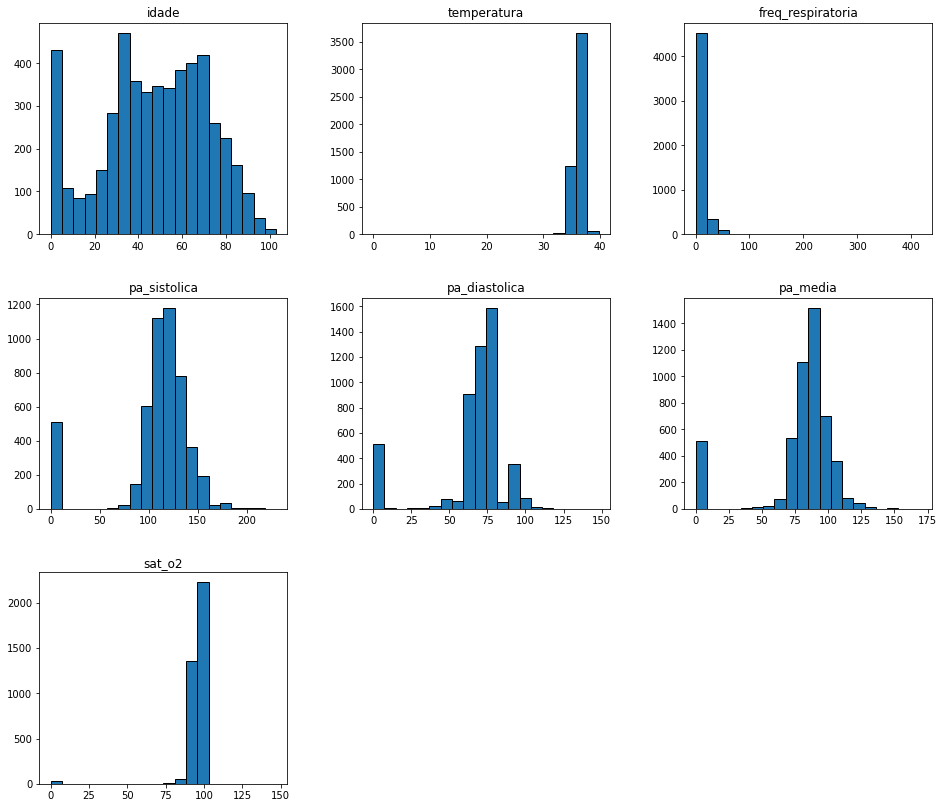

In [11]:
data.hist(bins=20, figsize=(16,14), edgecolor='black', grid=False)
plt.show()

Acima vemos os gráficos das variáveis. Enquanto alguns parecem se assimilar a uma distribuição gaussiana, os testes de normalidade anteriores indicam o contrário.

In [12]:
data.describe()

,idade,temperatura,freq_respiratoria,pa_sistolica,pa_diastolica,pa_media,sat_o2
count,5001.000000,4998.000000,4996.000000,4999.000000,4999.000000,4999.000000,3686.000000
mean,47.552090,36.018007,17.201361,107.180636,65.748750,79.515103,94.783234
std,24.132553,0.807237,11.474770,39.675560,24.716392,29.181843,9.419916
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,35.700000,16.000000,100.000000,60.000000,77.000000,94.000000
50%,49.000000,36.000000,18.000000,120.000000,70.000000,87.000000,96.000000
75%,66.000000,36.300000,19.000000,130.000000,80.000000,93.000000,98.000000
max,103.000000,39.700000,418.000000,230.000000,148.000000,170.000000,147.000000


Podemos notar que 75% dos pacientes possuia:
- Idade de até 66 anos
- Temperatura de até 36,3
- Frequência respiratória de até 19
- Pressão arterial sistólica de até 130
- Pressão arterial diastólica de até 80
- Pressão arterial média de 93
- Saturação do oxigênio em 98

O paciente mais novo possui 0 anos e o mais velho 103. Notamos que as demais variáveis possuem seu mínimo em zero, podendo ser um indício de que essa informação possa ser algum erro ou ausência do registro.

In [13]:
data[data.temperatura == 0]

,idade,setor,temperatura,freq_respiratoria,pa_sistolica,pa_diastolica,pa_media,sat_o2,alta.motivo
4376,43,2AP2,0.0,0.0,118.0,69.0,85.0,99.0,Melhorado


Na linha acima, notamos que o paciente com temperatura e frequência respiratória com registro 0 obteve *status* melhorado.

In [14]:
data[data.pa_media == 0]

,idade,setor,temperatura,freq_respiratoria,pa_sistolica,pa_diastolica,pa_media,sat_o2,alta.motivo
11,1,UTIP,33.0,4.0,0.0,0.0,0.0,93.0,Obito
18,1,UTIP,35.8,40.0,0.0,0.0,0.0,89.0,Obito
26,0,UTIP,36.0,48.0,0.0,0.0,0.0,93.0,Obito
58,1,UTIP,35.5,40.0,0.0,0.0,0.0,91.0,Obito
101,0,UTIP,34.8,50.0,0.0,0.0,0.0,100.0,Obito
...,...,...,...,...,...,...,...,...,...
4959,1,2AP2,36.1,38.0,0.0,0.0,0.0,96.0,Melhorado
4978,7,2AP2,37.5,27.0,0.0,0.0,0.0,98.0,Melhorado
4986,3,2AP2,36.0,0.0,0.0,0.0,0.0,96.0,Melhorado
4992,1,2AP2,36.3,36.0,0.0,0.0,0.0,90.0,Melhorado


Com relação ao valor de pressão arterial, vemos que tantos pacientes que vieram a óbitos quanto pacientes que se recuperaram possuem valores nulos. 

Valores de pressão arterial e saturação do oxigênio baixos que precisam ser investigados também.

In [15]:
data[data.pa_diastolica.between(1, 10)]

,idade,setor,temperatura,freq_respiratoria,pa_sistolica,pa_diastolica,pa_media,sat_o2,alta.motivo
1459,93,3AP1,36.7,20.0,190.0,10.0,70.0,93.0,Melhorado
4053,60,3AP3,36.1,16.0,160.0,10.0,60.0,96.0,Melhorado
4473,64,4AP2,36.1,19.0,160.0,10.0,60.0,98.0,Melhorado
4720,65,4AP2,36.1,20.0,160.0,10.0,60.0,98.0,Melhorado
4723,24,4AP1,37.1,20.0,140.0,10.0,53.0,99.0,Melhorado


In [16]:
data.describe(include=[object])

,setor,alta.motivo
count,5000,5001
unique,16,2
top,4AP1,Melhorado
freq,1034,4572


Dentre as variáveis categóricas, a maioria dos pacientes se encontrava no setor 4AP1 (cerca de 1034). No dataset que nos foi fornecido, há 16 setores no qual os pacientes se encontravam internados. Maior parte das altas ocorreu porque houve melhora no quadro dos pacientes (4572).

A seguir prosseguimos com uma análise visual dos nossos dados através de diagramas de dispersão. Esse diagrama normalmente utilizamos quando desejamos investigar como as variáveis se relacionam.

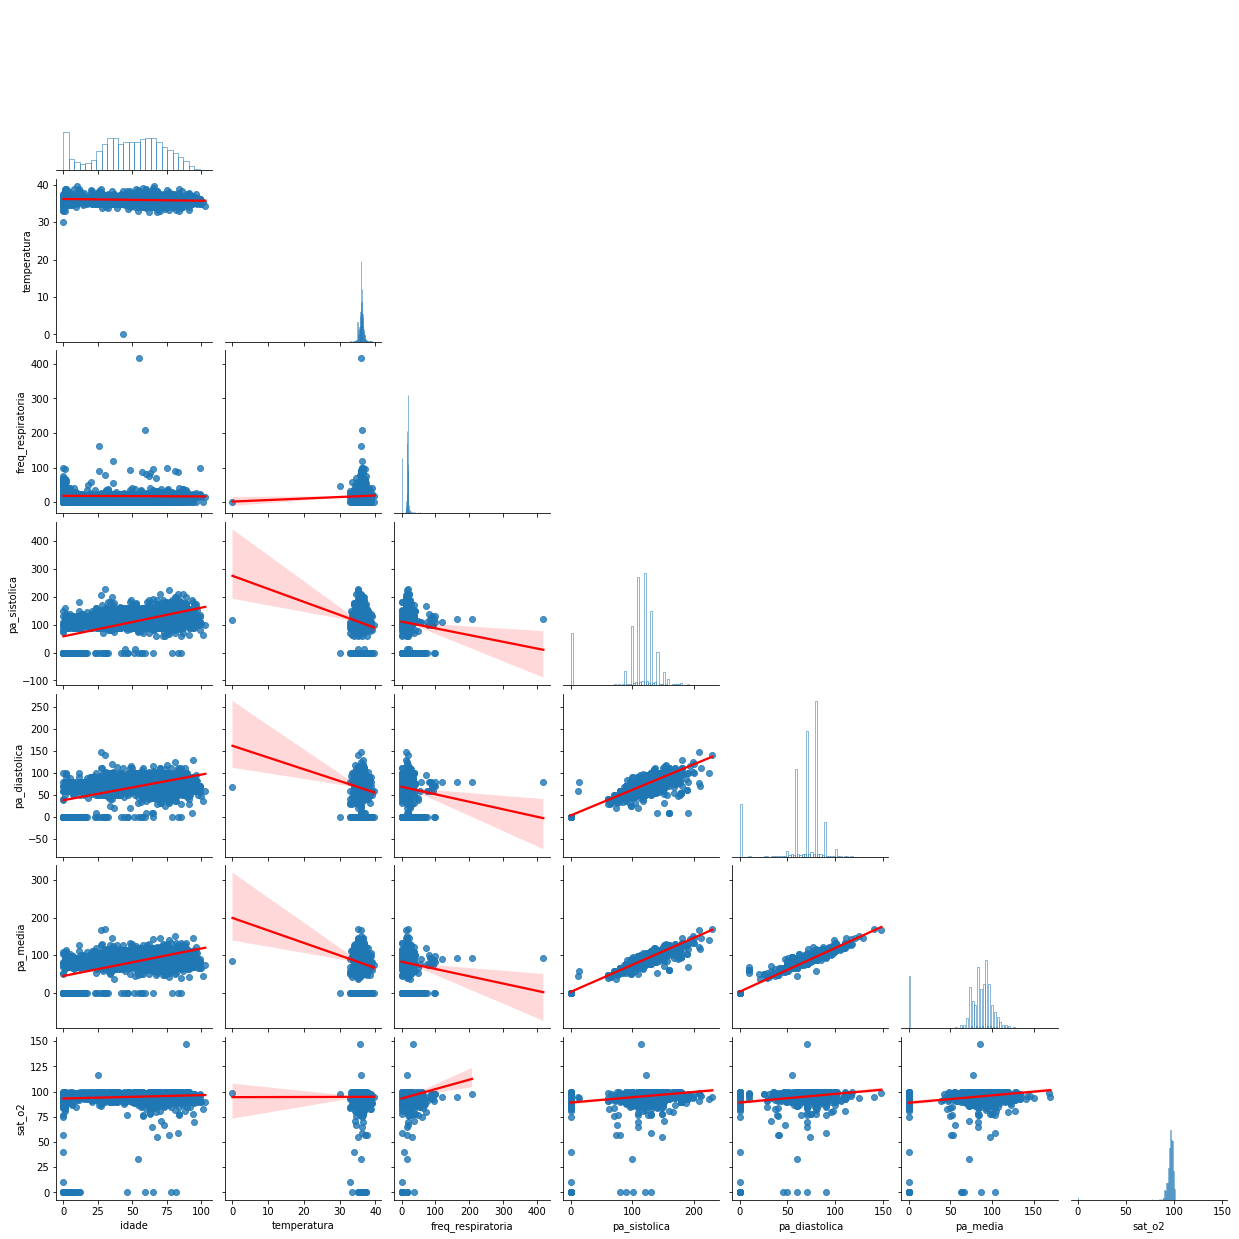

In [17]:
g = sns.pairplot(
    data,
    kind='reg',
    plot_kws={'line_kws':{'color':'red'}},
    diag_kws=dict(fill=False),
    corner=True
)
plt.show()

Através do *pairplot* acima gerado pela biblioteca de visualização Seaborn, podemos notar a presença de correlação em diversas variáveis, dentre as mais notórias podemos destacar:

- `pa_diastolica` aumenta a medida que a `pa_sistolica`
- `pa_media` com a `pa_sistolica` e com a `pa_diastolica`

As variáveis acima são esperadas que possuam correlação visível, pois ambas se referem a parâmetros de pressão arterial.

Outra correlação esperada seria que quando a `freq_respiratoria` aumenta quando `sat_o2` aumenta. Também notamos que quanto maior a `idade` maior os valores da pressão arterial.

Para ter um melhor esclarecimento sobre a correlação entre as variáveis, utilizamos o coeficiente de correlação de Pearson. Esse coeficiente assume valores em -1 e +1, uma correlação pode ser positiva ou negativa.

- positiva: quando uma variável aumenta a outra tende a aumentar
- negativa: quando uma variável aumenta a outra tende a decrescer

![](https://miro.medium.com/max/1400/1*nElSDIp1jloJiqWX7hniaQ.png)

Acima podemos observamos alguns diagramas de dispersão, e os valores de seus coeficientes, além do grau da correlação. A seguir utilizamos a biblioteca `seaborn` para mostrar de modo visual a correlação entre as variáveis do nosso dataset.

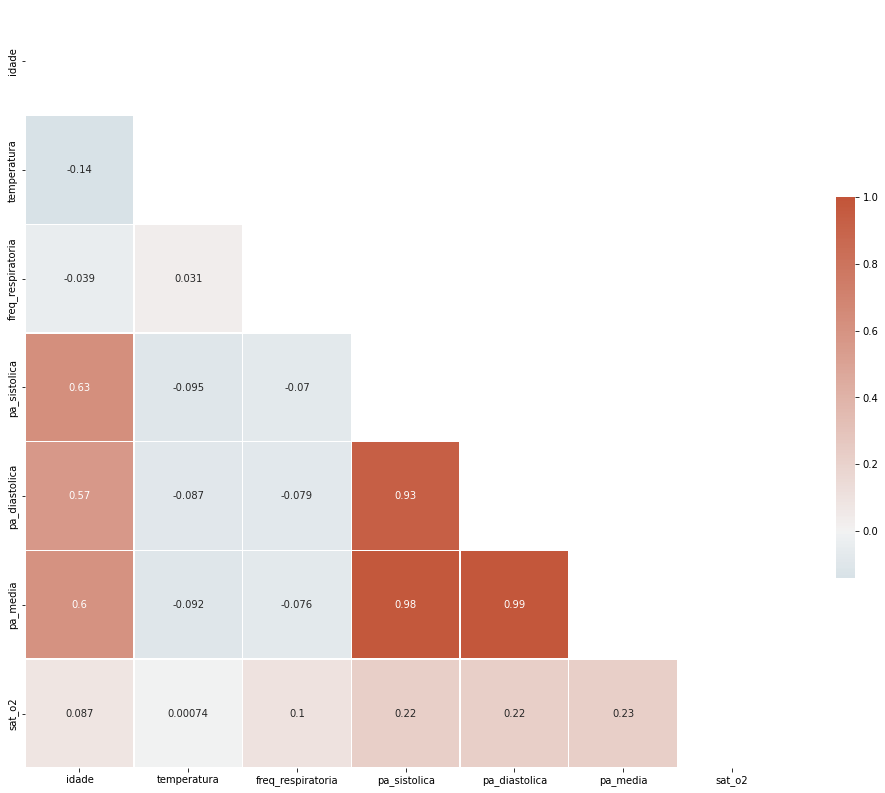

In [18]:
# Calcula a correlação entre pares de variáveis numéricas, ignorando valores
# faltantes. Por padrão utiliza o coeficiente de Pearson comentado 
# anteriormente.
corr = data.corr()

# Gera uma máscara bool para demarcar o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(18, 14))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Desenha um heatmap, o argumento mask nos permite remover a parte superior
# da visualização, reduzindo a poluição visual de informação repetida
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})

plt.show()

Podemos ver que as variáveis de pressão possuem correlação altamente positivas entre si. A idade também possui uma correlação altamente positiva com as variáveis de pressão.

Novamente, podemos notar que a pressão arterial possui correlação positiva com a saturação do oxigênio.

#Pré-processamento dos dados

**Interpolação para lidar com NANs**

Interpolações testadas: linear, quadrática, spline, polinomial. Todas tiveram resultados similares na classificação, com ambos o spline e polinomial de ordem 7 com os melhores resultados. Todas são opções melhores que simplismente excluir as linhas com NAN

In [2]:
data.isna().sum()

idade                   0
setor                   1
temperatura             3
freq_respiratoria       5
pa_sistolica            2
pa_diastolica           2
pa_media                2
sat_o2               1315
alta.motivo             0
dtype: int64

In [3]:
processed_data=data.interpolate('polynomial',order=7)
# processed_data=data.interpolate('spline',order=5)

In [4]:
processed_data.isna().sum()

idade                0
setor                1
temperatura          0
freq_respiratoria    0
pa_sistolica         0
pa_diastolica        0
pa_media             0
sat_o2               0
alta.motivo          0
dtype: int64

In [5]:
#Retirar o ultimo NAN
processed_data=processed_data.dropna()

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(processed_data['setor'].values)
processed_data['setor']=le.transform(processed_data['setor'].values)
le.classes_

array(['1AP1', '1AP2', '1AP2 - 126', '2AP1', '2AP2', '3AP1', '3AP2',
       '3AP3', '3AP3 - EPI', '4AP1', '4AP2', 'SEMI-CO', 'UIP', 'UTIC',
       'UTIG', 'UTIP'], dtype=object)

In [7]:
#Se quiser treinar sem o setor
# processed_data=processed_data.drop(columns=['setor'])

#Engenharia de Features

##Domain Features

De acordo com especificações do NEWS(https://www.sciencedirect.com/science/article/pii/S0883944118303769) extraímos características por meio de Binning. 
Binning significa algo como 'encaixotar', e a idéia é justamente encaixotar varíaveis contínuas em intervalos, obtendo assim variáveis categoricas informativas para o modelo. Ao analisar os resultados obtidos, aparenta-se haver um ganho de 1% no f1-score ao adicionar essas features.

Na tabela abaixo, vemos as variáveis contínuas de interesse pontuadas de 0 a 3. Se um paciente obtiver uma pontuação de (1-4) é considerado de baixo risco, (5-6) de médio risco, e sendo maior que (7) como alto risco.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0883944118303769-gr1_lrg.jpg"/>

In [8]:
import numpy as np
def binning(df):
  features = np.zeros((len(df), 5))

  #temperatura
  for i in range(len(df)):
    temperatura = df.iloc[i, 2]
    if temperatura <= 35:
        temperatura_bin = 3
    elif temperatura >= 39.1:
        temperatura_bin = 2
    elif (35.1 <= temperatura <= 36.0) | (38.1 <= temperatura <= 39.0):
        temperatura_bin = 1
    else:
        temperatura_bin = 0
    features[i, 0] = temperatura_bin
  
  #frequencia respiratoria
  respiracao = df.iloc[i, 3]
  if (respiracao < 8)|(respiracao > 25):
      respiracao_bin = 3
  elif 21 <= respiracao <= 24:
      respiracao_bin = 2
  elif 9 <= respiracao <= 11:
      respiracao_bin = 1
  else:
      respiracao_bin = 0
  features[i,1] = respiracao_bin

  #pressao sistolica
  sistolica = df.iloc[i, 4]  
  if (sistolica <= 100):
      sistolica_bin = 1
  elif (sistolica <= 90) & (sistolica >= 220):
      sistolica_bin = 3
  elif (sistolica >= 91) & (sistolica <= 100):
      sistolica_bin = 2
  elif (sistolica >= 101) & (sistolica <= 110):
      sistolica_bin = 1
  else:
      sistolica_bin = 0
  features[i, 2] = sistolica_bin

  #media
  media = df.iloc[i, 6]
  if media >= 70:
      media_bin = 0
  else:
      media_bin = 1
  features[i, 3] = media_bin

  #o2
  o2 = df.iloc[i, 6]
  if o2 <= 91:
      o2_bin = 3
  elif o2 >= 96:
      o2_bin = 0
  elif o2 >= 92 & o2 <= 93:
      o2_bin = 2
  elif o2 > 93 & o2 <= 95:
      o2_bin = 1
    
  features[i, 4] = o2_bin


  return features

In [9]:
features=binning(processed_data)
features=np.reshape(features,(5,5000))

In [10]:
processed_data['feature1']=features[0][:]
processed_data['feature2']=features[1][:]
processed_data['feature3']=features[2][:]
processed_data['feature4']=features[3][:]
processed_data['feature5']=features[4][:]

In [11]:
processed_data.head()

,idade,setor,temperatura,freq_respiratoria,pa_sistolica,pa_diastolica,pa_media,sat_o2,alta.motivo,feature1,feature2,feature3,feature4,feature5
0,87,14,36.0,18.0,128.0,75.0,93.0,91.0,Obito,1.0,0.0,1.0,1.0,1.0
1,53,1,35.4,14.0,117.0,67.0,84.0,100.0,Obito,0.0,0.0,0.0,0.0,0.0
2,63,14,36.4,40.0,149.0,75.0,100.0,78.0,Obito,0.0,0.0,0.0,0.0,0.0
3,84,14,36.4,40.0,149.0,75.0,100.0,78.0,Obito,0.0,0.0,0.0,0.0,0.0
4,99,10,36.3,16.0,80.0,60.0,67.0,94.0,Obito,0.0,0.0,0.0,0.0,0.0


#Treinamento de Modelos

##Setup

A tarefa de descobrir se uma pessoa vai abandonar pode ser vista como um problema de classificação, mas especificamente classificação binária. Nesse cenário, queremos tentar predizer se um paciente **vai melhorar** ou se **vai a óbito**. Há diversos tipos de algoritmos utilizados para problemas de classificação, algum dos mais populares que escolhemos explorar são:

- *Linear classifier*:  *logistic regression*
- *SVM*
- *Boosted trees classifier* (XGBoost)

Podemos notar que nosso conjunto de dados se encontra com as classes desbalanceadas, há mais paciente que melhoram do que os que vem a óbito. Nessa situação, caso o classificador preveja 'recuperado' para todas as classes, a acurácia é de aproximadamente 91\%.

\begin{align}
    accuracy =  \frac{TP + TN}{TP + TN + FP + FN} \\
    accuracy =  \frac{4572}{5001} = 0.9142
\end{align}

Desse modo, precisamos considerar outras métricas como:
$$ precision =\dfrac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$
$$ recall =\dfrac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

Outra métrica que utilizaremos é o *F1 Score* que é definida como:

\begin{align}
    F1 =  2 \times \frac{TPR \times TNR}{TNR + TPR} 
\end{align}

Maximizar a *precision* do óbito significa aumentar a exatidão da classificação de óbito pelo modelo (Mesmo que esteja deixando de prever óbitos).

Maximizar o *recall* (cobertura,revocação) do óbito significa o modelo conseguir acertar com uma alta proporção os óbitos que ocorrem (Mesmo que esteja prevendo melhoras como óbitos).

A partir do F1, podemos ter um balanço entre o *recall* e a *precision*. 



Outra métrica importante para a classificação média é a AUCROC (Area Under the Receiver Operating Characteristic). 

Um AUCROC de 0.5 corresponde a um chute, enquanto de um AUROC de 1 é um classificador perfeito. 

In [12]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score, accuracy_score

Dividir o dataset em treino teste e validação. A validação será utilizada para ajustarmos a pipeline com escolhas como pré-processamentos e parâmetros dos modelos. No final faremos a avaliação no conjunto de teste

In [13]:
def str2num(d):
  n=np.zeros(len(d))
  for i in range(len(d)):
    if(d[i]=='Melhorado'):
      n[i]=0
    else:
      n[i]=1
  return n

y=processed_data['alta.motivo'].values
X=processed_data.drop(['alta.motivo'], axis=1)

  
y=str2num(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=41)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=41)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(3500, 13)
(750, 13)
(750, 13)


In [14]:
X_train_df=X_train.copy()
X_valid_df=X_valid.copy()
X_test_df=X_test.copy()

In [15]:
print('Treino: Número de Melhorados',len(y_train)-y_train.sum(),', Número de Óbitos: ',y_train.sum())
print('Validação: Número de Melhorados',len(y_valid)-y_valid.sum(),', Número de Óbitos: ',y_valid.sum())
print('Teste: Número de Melhorados',len(y_test)-y_test.sum(),', Número de Óbitos: ',y_test.sum())

Treino: Número de Melhorados 3204.0 , Número de Óbitos:  296.0
Validação: Número de Melhorados 679.0 , Número de Óbitos:  71.0
Teste: Número de Melhorados 688.0 , Número de Óbitos:  62.0


In [16]:
if 'setor' in X_train_df.columns:
  X_train_df['setor']= le.inverse_transform(X_train_df['setor'].values)
  X_valid_df['setor']= le.inverse_transform(X_valid_df['setor'].values)
  X_test_df['setor']= le.inverse_transform(X_test_df['setor'].values)

**Balanceamento dos dados**

In [17]:
!pip install imbalanced-learn

Foram experimentados vários métodos de oversampling e undersampling, importados abaixo.

In [18]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE 
from imblearn.pipeline import make_pipeline as imbl_pipe

##Treino padrão

Na experimentação, o Standard Scaler foi a normalização que impactou mais positivamente no resultado em todos os casos. Fazer undersampling (diminuir a classe marjoritária dos  melhorando) se demonstrou melhor que realizar oversampling(aumentar a classe minoritária de obitos artificialmente).
O método de undersampling ALLKNN foi o que em alguns casos mais impactou positivamente.

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

In [20]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

clf = imbl_pipe(
    StandardScaler(),
    AllKNN(),
    LogisticRegression(random_state=0)
) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       679
         1.0       0.83      0.35      0.50        71

    accuracy                           0.93       750
   macro avg       0.88      0.67      0.73       750
weighted avg       0.93      0.93      0.92       750



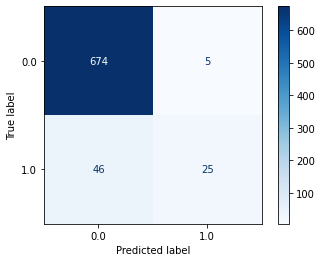

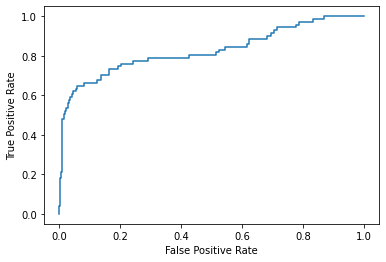

In [39]:
ConfusionMatrixDisplay.from_estimator(clf,X_valid, y_valid,cmap='Blues')
y_score = clf.decision_function(X_valid)

fpr, tpr, _ = roc_curve(y_valid, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

In [19]:
aucroc = roc_auc_score(y_valid, y_pred)
print('AUCROC: ' + str(aucroc))

AUCROC: 0.538250119272335


Os resultados da regressão logística foram os piores dentre os testados.

In [ ]:
clf = imbl_pipe(
    StandardScaler(),
    SVC()
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       679
         1.0       0.92      0.65      0.76        71

    accuracy                           0.96       750
   macro avg       0.94      0.82      0.87       750
weighted avg       0.96      0.96      0.96       750



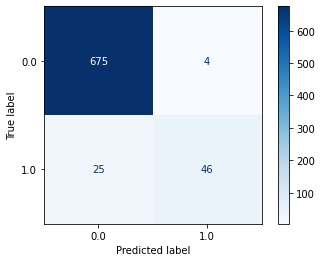

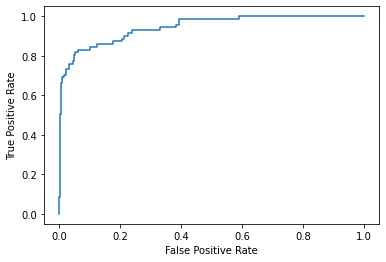

In [41]:
ConfusionMatrixDisplay.from_estimator(clf,X_valid, y_valid,cmap='Blues')
y_score = clf.decision_function(X_valid)

fpr, tpr, _ = roc_curve(y_valid, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

In [ ]:
aucroc = roc_auc_score(y_valid, y_pred)
print('AUCROC: ' + str(aucroc))

AUCROC: 0.8209981538716837


Aqui obtivemos o resultado com melhor precisão de óbito, e   recall acima de 50%. Esse resultado significa que o modelo é bastante conservador nas suas escolhas (escolhendo poucos como óbitos, perdendo vários casos que são óbitos), mas possue uma exatidão significante de 98% quando diz que um paciente vai a óbito. Se na vida real a prioridade for um modelo que nos alerte para para caso de óbito, esse é o que queremos. Não foi utilizado nenhum método de balanceamento pois diminuia a precision sem grande ganhos no recall.

In [ ]:
clf = imbl_pipe(
    StandardScaler(),
    AllKNN(),
    XGBClassifier()
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       679
         1.0       0.74      0.80      0.77        71

    accuracy                           0.95       750
   macro avg       0.86      0.89      0.87       750
weighted avg       0.96      0.95      0.96       750



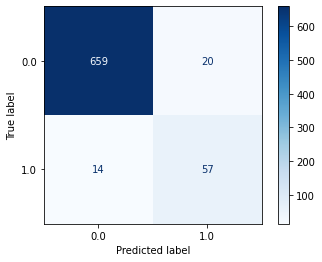

In [46]:
ConfusionMatrixDisplay.from_estimator(clf,X_valid, y_valid,cmap='Blues')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


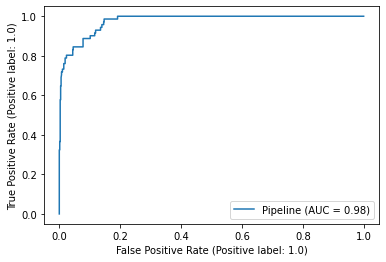

In [45]:
metrics.plot_roc_curve(clf, X_valid, y_valid) 

In [ ]:
y_score = clf.decision_function(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

In [ ]:
aucroc = roc_auc_score(y_valid, y_pred)
print('AUCROC: ' + str(aucroc))

AUCROC: 0.8866809102034889


Os melhores resultados balanceando a precisão e recall foram obtidos pelo XGBoost. Escolhemos esse modelo para fazer uma busca exaustiva nos seus parâmetros mais abaixo. 

##Busca de hiperparâmetros

Realizamos aqui a busca por hiperparâmetros no XGBoost. A busca é feita por um modelo de otimização bayesiana onde ele vai experimentando alterar os hiperparâmetros do xgboost menos promissores e mantendo os mais promissores. Com isso é possivel evitar o tempo custoso de uma grid serch que experimenta todas as combinações possíveis de hiperparâmetros.

In [19]:
ss=StandardScaler()
ss.fit(X_train)
X_train=ss.transform(X_train)
X_valid=ss.transform(X_valid)

In [20]:
imb=AllKNN(n_neighbors=3)
# imb=SMOTE()
imb.fit(X_train,y_train)
X_train,y_train=imb.fit_resample(X_train,y_train)
X_train.shape

(3292, 13)

In [21]:
from sklearn.metrics import roc_auc_score, accuracy_score
import xgboost as xgb
from hyperopt import STATUS_OK, hp, fmin, tpe

def optim_XGB(X_train, y_train, X_val, y_val):
    " Otimização de Hiperparâmetros "
    train = xgb.DMatrix(X_train, label=y_train)
    val = xgb.DMatrix(X_val, label=y_val)
    X_val_DM = xgb.DMatrix(X_val)

    def objective(params):
        xgb_model = xgb.train(params, dtrain=train, num_boost_round=1000, evals=[(val, 'eval')],
                              verbose_eval=False, early_stopping_rounds=80)
        y_vd_pred = xgb_model.predict(X_val_DM, ntree_limit=xgb_model.best_ntree_limit)
        y_val_class = [0 if i <= 0.5 else 1 for i in y_vd_pred]


        acc = accuracy_score(y_val, y_val_class)
        # acc = roc_auc_score(y_val, y_val_class)
        loss = 1 - acc

        return {'loss': loss, 'params': params, 'status': STATUS_OK}


    max_depths = [3, 4, 5, 7, 9]
    min_child_weights = [1, 5, 10, 15]
    learning_rates = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2]
    subsamples = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytrees = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    reg_alphas = [0.0, 0.005, 0.01, 0.05, 0.1]
    reg_lambdas = [0.8, 1, 1.5, 2, 4]
    gammas = [0.5, 1, 1.5, 2, 5, 7]

    space = {
        'max_depth': hp.choice('max_depth', max_depths),
        'min_child_weight': hp.choice('min_child_weight', min_child_weights),
        'learning_rate': hp.choice('learning_rate', learning_rates),
        'subsample': hp.choice('subsample', subsamples),
        'colsample_bytree': hp.choice('colsample_bytree', colsample_bytrees),
        'reg_alpha': hp.choice('reg_alpha', reg_alphas),
        'reg_lambda': hp.choice('reg_lambda', reg_lambdas),
        'gamma': hp.choice('gamma', gammas),
    }

    otimo = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)

    melhores_parametros = {'max_depth': max_depths[(otimo['max_depth'])],
                  'min_child_weight': min_child_weights[(otimo['min_child_weight'])],
                  'learning_rate': learning_rates[(otimo['learning_rate'])],
                  'subsample': subsamples[(otimo['subsample'])],
                  'colsample_bytree': colsample_bytrees[(otimo['colsample_bytree'])],
                  'reg_alpha': reg_alphas[(otimo['reg_alpha'])],
                  'reg_lambda': reg_lambdas[(otimo['reg_lambda'])],
                  'gamma': gammas[(otimo['gamma'])]
                  }

    return melhores_parametros

melhores_parametros = optim_XGB(X_train, y_train, X_valid, y_valid)
melhores_parametros

100%|██████████| 100/100 [01:12<00:00,  1.38it/s, best loss: 0.03066666666666662]


{'colsample_bytree': 0.6,
 'gamma': 1.5,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 5,
 'reg_alpha': 0.01,
 'reg_lambda': 4,
 'subsample': 0.5}

Várias funções objetivo para o otimizador bayesiano foram testadas(acurácia, f1, recall, etc), com poucas diferenças entre si no resultado final. Desse modo mantivemos a métrica da acurácia como função objetivo.

In [22]:
melhores_parametros

{'colsample_bytree': 0.6,
 'gamma': 1.5,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 5,
 'reg_alpha': 0.01,
 'reg_lambda': 4,
 'subsample': 0.5}

In [23]:
model = xgb.XGBClassifier(max_depth = melhores_parametros['max_depth'],
                                  min_child_weight = melhores_parametros['min_child_weight'],
                                  eta = melhores_parametros['learning_rate'],
                                  n_estimators = 1000,
                                  subsample = melhores_parametros['subsample'],
                                  colsample_bytree = melhores_parametros['colsample_bytree'],
                                  reg_alpha = melhores_parametros['reg_alpha'],
                                  reg_lambda = melhores_parametros['reg_lambda'],
                                  gamma = melhores_parametros['gamma'],
                                  objective = "binary:logistic"
                                  )

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='error',
              early_stopping_rounds=80, verbose=False)

XGBClassifier(colsample_bytree=0.6, eta=0.2, gamma=1.5, min_child_weight=5,
              n_estimators=1000, reg_alpha=0.01, reg_lambda=4, subsample=0.5)

In [24]:
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       679
         1.0       0.91      0.75      0.82        71

    accuracy                           0.97       750
   macro avg       0.94      0.87      0.90       750
weighted avg       0.97      0.97      0.97       750



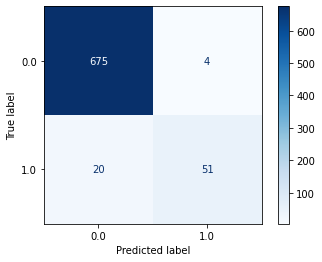

In [54]:
ConfusionMatrixDisplay.from_estimator(model,X_valid, y_valid,cmap='Blues')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


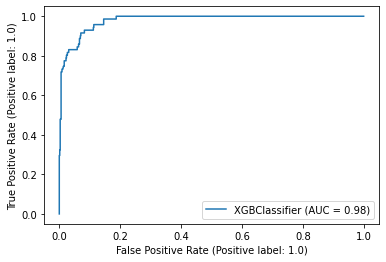

In [55]:
metrics.plot_roc_curve(model, X_valid, y_valid) 

##Teste Final e Salvar modelos

In [46]:
X_test=ss.transform(X_test)

In [47]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       688
         1.0       0.46      0.26      0.33        62

    accuracy                           0.91       750
   macro avg       0.70      0.62      0.64       750
weighted avg       0.90      0.91      0.90       750



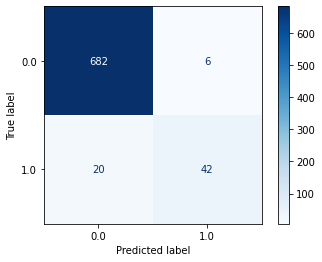

In [59]:
ConfusionMatrixDisplay.from_estimator(model,X_test, y_test,cmap='Blues')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


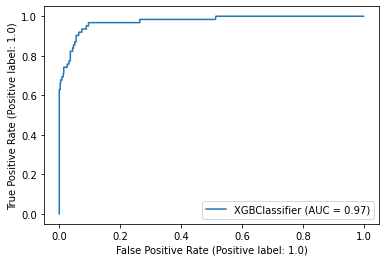

In [60]:
metrics.plot_roc_curve(model, X_test, y_test) 

In [26]:
from joblib import dump, load
dump(ss, 'scaler.joblib') 
dump(model, 'xgb_model.joblib') 
dump(le, 'le.joblib') 

['le.joblib']

In [31]:
from joblib import dump, load
dump(ss, 'nosection_scaler.joblib') 
dump(model, 'nosection_xgb_model.joblib') 

['nosection_xgb_model.joblib']

#Explicabilidade do Modelo

Todos os modelos que foram treinados e que obtiveram melhores resultados tem uma desvantagem: São do tipo Black Box. Isso quer dizer que não somos capazes naturalmente de entender os processos que levaram o modelo a fazer uma classificação. 

A área de explicabilidade na IA é um campo recente que busca desenvolver métodos que consigos penetra nessa black box, e nos trazer insights sobre que informações o modelo considera na sua tomada de decisão.

In [56]:
!pip install shap

A técnica que adotamos para explicar as decisões do modelo se chama Shapley Values...

In [61]:
import shap
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
labels=['Melhorado','Obito']

**Exemplo 1**: Explicando a predição do modelo sobre o paciente melhorar. 

O numero em negrito é o score do modelo para essa observação. Pontuações maiores levam ao modelo predizer 1 (Óbito), e pontuações menores levam a 0 (Melhorando).
As features que são de importância para fazer essa predição estão em vermelho e azul, onde as vermelhas empurraram o score positivamente, e as azuis empurraram negativamente. As Features que tiveram um impacto maior no score estão mais próximas da divisa entre o vermelho e o azul, e o tamanho do seu impacto é representado pelo tamanho da sua barra.

In [69]:
paciente=2
print(X_test_df.iloc[paciente])
print(labels[int(y_test[paciente])])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[paciente,:], X_test_df.iloc[paciente,:])

idade                  67
setor                3AP1
temperatura            36
freq_respiratoria      18
pa_sistolica          100
pa_diastolica          70
pa_media               80
sat_o2                 97
feature1                0
feature2                0
feature3                0
feature4                0
feature5                0
Name: 3345, dtype: object
Melhorado


Nesse caso, as features de idade, temperatura, frequência respiratória foram as que mais 'empurraram' o modela a classificar o óbito, enquanto o setor e a média empurraram em menor proporção para a melhora.

In [ ]:
paciente=10
print(y_test[paciente])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[paciente,:], X_test_df.iloc[paciente,:])

0.0


**Exemplo 2**: explicando a decisão de que um paciente vai a óbito

In [68]:
paciente=7
print(X_test_df.iloc[paciente])
print(labels[int(y_test[paciente])])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[paciente,:], X_test_df.iloc[paciente,:])

idade                     24
setor                   UTIG
temperatura               37
freq_respiratoria         13
pa_sistolica             110
pa_diastolica             70
pa_media                  83
sat_o2               26.1228
feature1                   0
feature2                   0
feature3                   0
feature4                   0
feature5                   0
Name: 374, dtype: object
Obito


**Visualizando as categorias de mais importância em todo o dataset de teste.**

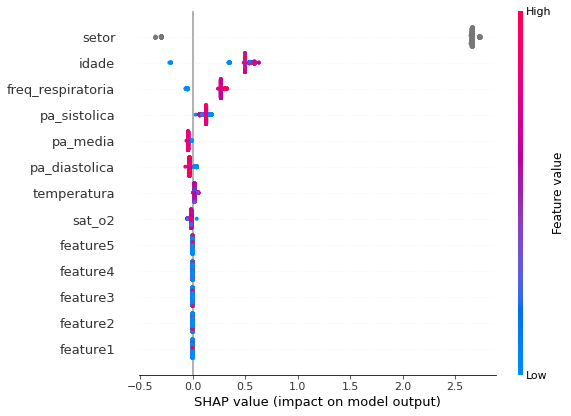

In [50]:
shap.initjs()
shap.summary_plot(shap_values, X_test_df)

Aqui podemos observar as features que mais impactam na tomada de decisão do modelo: o setor é de longe a variável mais importante na classificação, seguida pela idade do paciente, a respiração e a pressão sistólica. As de menos importância são a temperatura, saturação, e as features construídas atraves do sistema NEWS.

**Visualizando as features mais importantes**

invalid value encountered in true_divide
invalid value encountered in true_divide


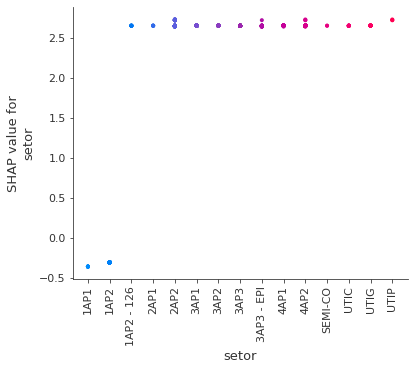

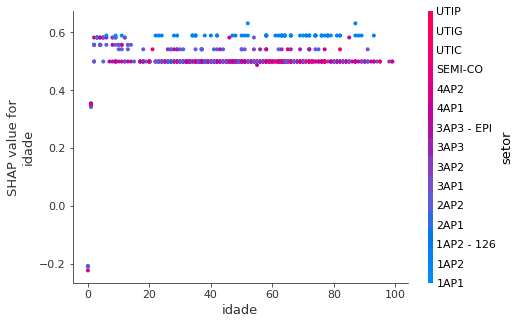

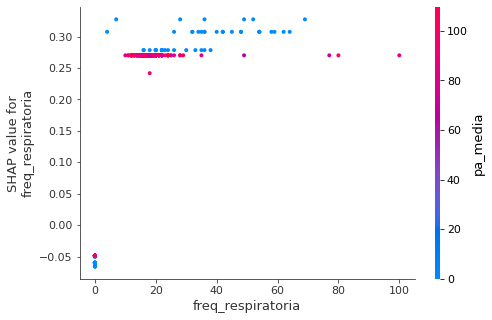

In [52]:
import numpy as np
#ordena os indices de fetures por sua importancia no modelo
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# SHAP plots das features mais importantes
for i in range(3):
    shap.dependence_plot(top_inds[i], shap_values, X_test_df)

Por último, podemos analisar algumas relações entre as features, sendo de mais interesse na tomada de decisão o setor, onde observamos que os setores de UTI empurram a decisão para óbito, e as 1AP1 e 1AP2 para recuperação. 
Na segunda imagem vemos a relação da idade com o setor, e que pro modelo, independente da idade, os setores de UTI empurram a predição para óbito(vermelho), euquanto que os da 1AP empurram para melhora(azul). Quando as features de frequência respiratória e pressão média, vemos que quanto maior a pressão média, dentro de uma faixa de respiração de 0 a 40, mais é impactado no óbito. Na faixa de respiração de 20 a 60 com uma pressão média mais baixa, faz o modelo tender a decidir pela melhora.